# Fuzzy Annotation
Annotating the intermediate outputs of NER datasets where the song attributes (title, performer) could not be found in the YT metadata.

In [1]:
import warnings
import pandas as pd

warnings.filterwarnings("ignore")


data_datacos = pd.read_parquet("../data/analysis/datacos_notitle.parquet")
data_shs = pd.read_parquet("../data/analysis/shs100k2_notitle.parquet")


# Spaczz
More infos in the [official repo of spaczz](https://github.com/gandersen101/spaczz). Here, the same matching function is used via [RapidFuzz](https://rapidfuzz.github.io/RapidFuzz/). We also tried [LexiFuzz](https://github.com/hanifabd/lexifuzz-ner), but realized it is less robust (errors for some weird strings with Chinese and Japanese chars) and less flexible (only implements the normalized Indel distance).



In [2]:
from typing import List, Tuple
import spacy
from spaczz.matcher import FuzzyMatcher
from collections.abc import Iterable

nlp = spacy.blank("en")

def __apply_spaczz(row: pd.Series, min_ratio: float = 90.0, func: str = "simple", 
                   text_attr: str = "yt_processed", 
                   attrs: List[str] = ["title", "performer"]) -> List[Tuple[str, int, int, str]]:
    """Apply spaczz to a row in a dataset dataframe
    Args:
        row (pd.Series): row in the dataframe
        min_ratio (int): minimum matching ratio.
        func (str): fuzzy matching function
        text_attr (str, optional): Column with the text. Defaults to "yt_processed".
        attrs (List[str], optional): Entities to find. Defaults to ["title", "performer"].
    Returns:
        Tuple[str, int, int, str]: Matched entities as per LexiFuzz or None.
    """
    doc = nlp(row[text_attr])

    # init entities
    matcher = FuzzyMatcher(nlp.vocab)
    for attr in attrs:
        ents = row[attr]
        if isinstance(ents, str):
            ents = [ents]
        for ent in ents:
            matcher.add(attr, [nlp(ent)], kwargs=[{
                "fuzzy_func": func, "min_r": min_ratio}])
    
    matches = matcher(doc)

    return matches
    

### Match...

In [3]:
print("Match with Indel distance")
series_simple = data_shs.apply(__apply_spaczz, args=(90, "simple",), axis=1)
print("Match with token ratio")
series_token = data_shs.apply(__apply_spaczz, args=(90, "token",), axis=1)
print("Match with token ratio")
series_partial = data_shs.apply(__apply_spaczz, args=(90, "partial_token",), axis=1)


Match with Indel distance
Match with token ratio
Match with token ratio


### Experiment with Thresholds

In [4]:
def has_any_ent(t_list: List[tuple], attr: str, min_ratio: float) -> bool:
    """From list of tuples (output of spaczz), return if any ent with min. ratio is included.
    Args:
        t_list (List[tuple]): output of spaczz matcher
        attr (str): attribute name
        min_ratio (float): 
    Returns:
        bool: whether match is included
    """
    return any([
        (name, start, end, ratio, entity) for (name, start, end, ratio, entity) in t_list 
        if name == attr and ratio >= min_ratio])

def extracted_ratio(series: pd.Series, min_ratio: float, attr: str) -> float:
    """Get the ratio of successfully extracted entities with a fuzzy approach.
    Args:
        series (pd.Series): series with oututs from spaczz
        min_ratio (float): 
        attr (str): attribute name (eg. title or performer)
    Returns:
        float: ratio of successfully extracted
    """
    return series.apply(has_any_ent, args=(attr, min_ratio,)).sum() / series.count()
    

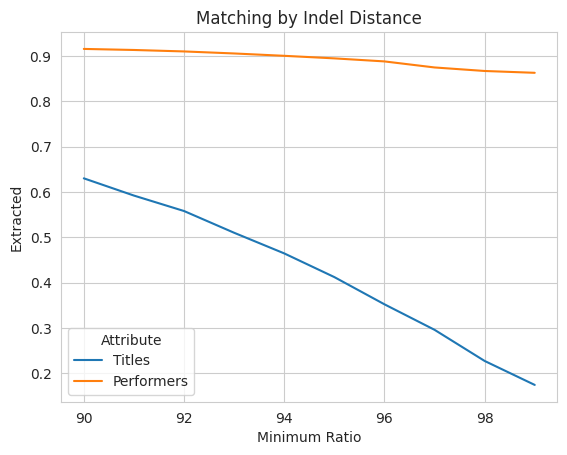

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_experiment_df(series: pd.Series) -> pd.DataFrame:
    """Get df for plotting
    Args:
        series (pd.Series): 
    Returns:
        pd.DataFrame: 
    """
    min_ratios = [i for i in range(90, 100)]
    title_extracted = []
    performer_extracted = []

    for i in min_ratios:
        title_extracted.append(extracted_ratio(series, i, "title"))
        performer_extracted.append(extracted_ratio(series, i, "performer"))

    return pd.DataFrame({
        "Minimum Ratio": min_ratios, 
        "Titles": title_extracted,
        "Performers": performer_extracted}).melt(id_vars="Minimum Ratio", var_name="Attribute", value_name="Extracted")

sns.set_style("whitegrid")


sns.lineplot(data=get_experiment_df(series_simple), x="Minimum Ratio", y="Extracted", hue="Attribute")
plt.title("Matching by Indel Distance")
plt.show()


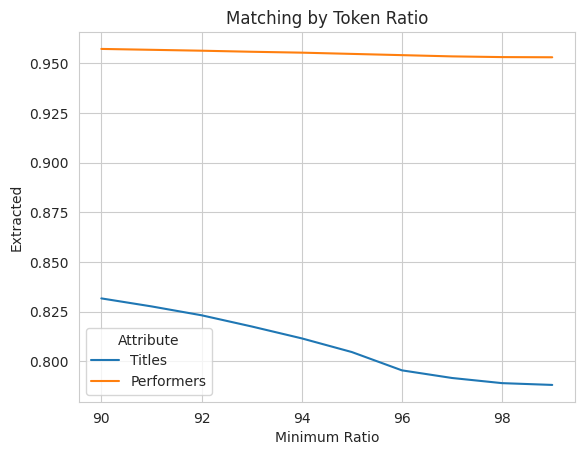

In [6]:
sns.lineplot(data=get_experiment_df(series_token), x="Minimum Ratio", y="Extracted", hue="Attribute")
plt.title("Matching by Token Ratio")
plt.show()


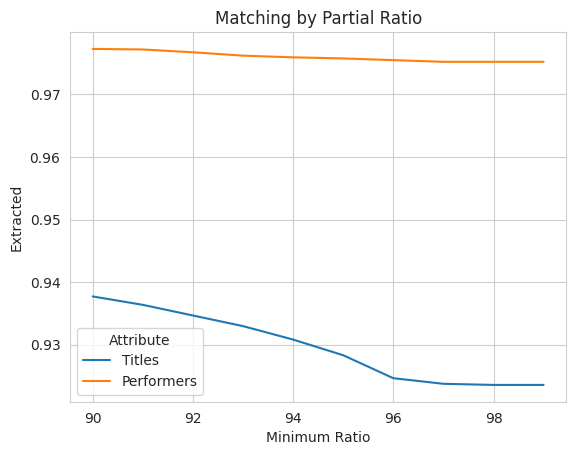

In [7]:
sns.lineplot(data=get_experiment_df(series_partial), x="Minimum Ratio", y="Extracted", hue="Attribute")
plt.title("Matching by Partial Ratio")
plt.show()


### Examples
#### Token ratio matches, but Indel not
We investigate where the token ratio matches, but not the Indel distance.

In [8]:
# mask: token matches, but not Indel
mask = ~series_simple.apply(
    has_any_ent, args=("title", 99)) & series_token.apply(has_any_ent, args=("title", 99))

data_shs.loc[mask, ["yt_processed", "title"]].sample(20)


,yt_processed,title
62952,"claude françois ""j'ai joué et puis j'ai perdu""...",[J'ai joue et j'ai perdu]
19658,"greta keller "" johnny,wenn du geburtstag hast ...","[Jonny, wenn du Geburtstag hast]"
22290,jack lukeman (aka jack l) amsterdam. pigshavec...,[Port of Amsterdam]
5776,belfast belle ( i'll tell me ma) lick the tins...,[The Belle of Belfast City]
13803,bob andy and marcia griffiths - it's a rocking...,[It's a Rockin' Good Way]
14184,pearl - neverending story (extended version). ...,[The Neverending Story]
1523,robson & jerome - pretty woman. rockabilly dav...,"[Oh, Pretty Woman]"
107133,2 degrees east 3 degrees west. eric herbelin. ...,"[Two Degrees East, Three Degrees West]"
13415,carl smith - how i love them old song. dvdman4...,[How I Love Them Old Songs]
32599,doris day-i remember april. moonsunshine. musi...,[I'll Remember April]


In [11]:
# mask: nothing matches
mask = ~series_simple.apply(
    has_any_ent, args=("title", 99)) & ~series_token.apply(
        has_any_ent, args=("title", 99)) & ~series_partial.apply(
            has_any_ent, args=("title", 99)
        )

data_shs.loc[mask, ["yt_processed", "title"]].sample(20)


,yt_processed,title
97738,xentrix : ghostbusters. sassassin. funny video...,[Ghost Busters]
2431,whiteroom - performed by seppo valjakka. illi ...,[White Room]
104303,stamatis spanoudakis - autumn. stamatis spanou...,[Ring Ring]
51973,rocky roberts & the airedales (u.s.a) - reach ...,[Gira gira]
104014,al and bunky - homework - exodus. raresoulie. ...,[Home Work]
33669,bewitched - rod stewart & cher. milaraven. ded...,"[Bewitched, Bothered and Bewildered]"
43418,vikki carr - meditación. publibag.,[Meditation]
44945,"giorgia fumanti ""aranjuez"" live at place des a...","[Aranjuez, mon amour]"
74658,the saw doctors - to win just once. sawdoctors...,[Teenage Kicks]
94327,toril nybrott - vårsøg. torilnybrott. sang: to...,[Varsg]


### Obeservations:
- if enclosed in `"` or `'`, the `partial_ratio` might help as well


## LexiFuzz (not used anymore)
More details about this approach [in the official repository](https://github.com/hanifabd/lexifuzz-ner). Under the hood, the **normalized Indel distance** is used via [`fuzz.ratio`](https://rapidfuzz.github.io/RapidFuzz/Usage/fuzz.html).



In [10]:
from typing import List, Dict, Union
from lexifuzz_ner.ner import find_entity

def __apply_lexifuzz(row: pd.Series, min_ratio: int = 90, text_attr: str = "yt_processed", 
                     attrs: List[str] = ["title", "performer"]) -> Union[Dict[str, Union[str, List]], None]:
    """Apply LexiFuzz to a row in a dataset dataframe
    Args:
        row (pd.Series): row in the dataframe
        min_ratio (int): minimum matching ratio.
        text_attr (str, optional): Column with the text. Defaults to "yt_processed".
        attrs (List[str], optional): Entities to find. Defaults to ["title", "performer"].
    Returns:
        Union[Dict[str, Union[str, List]], None]: Matched entities as per LexiFuzz or None.
    """
    # init entities
    d = {attr: list(row[attr]) for attr in attrs}
    try: 
        return find_entity(row[text_attr], d, min_ratio=min_ratio)
    except:
        print("Could not be matched!")
        return 
        
